In [30]:
%reset -f

In [31]:
!pip install -q fastparquet

In [32]:
!pip install lightgbm --config-settings=cmake.define.USE_CUDA=ON

In [40]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from category_encoders import TargetEncoder
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import re
import matplotlib.pyplot as plt

# 📥 Загрузка датасета

In [34]:
# данные о реальном спросе
real_demand = pd.read_parquet('/kaggle/input/datasets/faibus/diploma/real_demand_data.parquet', engine='fastparquet')

# данные о праздниках 
holidays = pd.read_excel('/kaggle/input/datasets/faibus/diploma/holidays.xlsx')
holidays['Holidays'] = pd.to_datetime(holidays['Holidays'], format='%Y.%m.%d')

# данные о погоде
weather = pd.read_csv('/kaggle/input/datasets/faibus/diploma/weather.csv')

# данные о характеристиках SKU
sku_charasterictics = pd.read_parquet('/kaggle/input/datasets/faibus/diploma/sku_features.parquet', engine='fastparquet')

# данные о днях промо
promo_days = pd.read_parquet('/kaggle/input/datasets/faibus/diploma/promo_days.parquet', engine='fastparquet')


# нормализуем целевую переменную 
# применяем лог-преобразование к столбцу 'real_demand'
real_demand['real_demand'] = np.log(real_demand['real_demand'] + 1)

# 📚 Генерация, создание фичей

In [35]:
# джойним характеристики SKU
real_demand = pd.merge(real_demand, sku_charasterictics, how = 'left', on = 'SKU_id')

# джойним промо-дни
real_demand = pd.merge(real_demand, promo_days, how = 'left', on = ['date', 'SKU_id'])

# заполяем пропуски в промо-днях значением False
real_demand['is_promo'] = real_demand['is_promo'].fillna(False)

# генерим временные фичи
real_demand['month'] = real_demand['date'].dt.month
real_demand['day'] = real_demand['date'].dt.day                    # номер дня внутри месяца (1-31)
real_demand['dayofweek'] = real_demand['date'].dt.dayofweek + 1
real_demand['week'] = real_demand['date'].dt.isocalendar().week
real_demand['quarter'] = real_demand['date'].dt.quarter
real_demand['year'] = real_demand['date'].dt.year
real_demand['dayofyear'] = real_demand['date'].dt.dayofyear        # номер дня внутри года (1-365)

# создаём дни праздников (корректнее сказать "признак выходных")
real_demand['is_holiday'] = real_demand['date'].isin(holidays['Holidays'])

/tmp/ipykernel_55/309843400.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  real_demand['is_promo'] = real_demand['is_promo'].fillna(False)


### 🪟 Rolling Window Features (скользящие средние)

In [36]:
# Создаем скользящие средние
# Используем shift(1) чтобы не использовать текущий день
for window in [7, 21, 35]:
    real_demand[f'rolling_mean_{window}'] = real_demand.groupby('SKU_id')['real_demand'].transform(
        lambda x: x.shift(1).rolling(window, min_periods=1).mean()
    )

# ✂️ Split: Train & Test

In [37]:
# Последние 15 дней для теста
test_end_date = real_demand['date'].max()
test_start_date = test_end_date - pd.Timedelta(days=14)

# test_start_date = '2025-09-16'

# Разделение на train и test
train = real_demand[real_demand['date'] < test_start_date].copy()
test = real_demand[real_demand['date'] >= test_start_date].copy()

# для теста копируем значения скользящих средних с последнего дня трейна
last_train_date = train['date'].max()
last_values = train[train['date'] == last_train_date][['SKU_id', 'rolling_mean_7', 'rolling_mean_21', 'rolling_mean_35']]

# Убираем старые значения из теста и добавляем замороженные
test = test.drop(columns=['rolling_mean_7', 'rolling_mean_21', 'rolling_mean_35'], errors='ignore')
test = test.merge(last_values, on='SKU_id', how='left')

# ⛓️ ML Pipeline

In [38]:
#######################
# старт трансформеров #
#######################

# Энкодер категориальных колонок

cat_cols = ['Category4', 'Brand', 'SupplierID']
time_cols = ['month', 'day', 'dayofweek', 'week', 'quarter', 'year', 'dayofyear']
rolling_cols = ['rolling_mean_7', 'rolling_mean_21', 'rolling_mean_35']
binary_cols = ['is_promo', 'is_holiday']

feature_cols = cat_cols + time_cols + rolling_cols + binary_cols

col_transformer_encoder = ColumnTransformer(
    transformers=[          
        # используем OHE для колонок, где уникальных значений <= 5
        ('OneHotEncoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), ['Category4']),
        
        # используем MTE иначе
        ('MeanTargetEncoder', TargetEncoder(), ['Brand', 'SupplierID'])
    ],
    remainder='passthrough',           # Это чтобы не дропнуть колонки, которых трансформер не касается
    verbose_feature_names_out=False    # Оставляем оригинальные названия колонок
).set_output(transform='pandas')       # Трансформер будет возвращать pandas


# Создаем пайплайн
pipeline = Pipeline([
    ('encoder', col_transformer_encoder),
    ('scaler', StandardScaler().set_output(transform='pandas'))  # для деревьев необязательно, но оставим
])


# Подготавливаем X и y
X_train = train[feature_cols]
y_train = train['real_demand']

X_test = test[feature_cols]
y_test = test['real_demand']  

######################
# НАПРЯГАЕТ ЭТОТ ШАГ #
######################
# Заполняем пропуски в числовых колонках
numeric_cols = time_cols + rolling_cols
for col in numeric_cols:
    if col in X_train.columns and X_train[col].isnull().any():
        print(f"Заполняем пропуски в train.{col}: {X_train[col].isnull().sum()}")
        X_train.loc[:, col] = X_train[col].fillna(X_train[col].mean())
    if col in X_test.columns and X_test[col].isnull().any():
        print(f"Заполняем пропуски в test.{col}: {X_test[col].isnull().sum()}")
        X_test.loc[:, col]= X_test[col].fillna(X_train[col].mean())


def clean_column_names(df):
    """Очищает названия колонок от специальных символов"""
    df.columns = [re.sub(r'[^a-zA-Z0-9_]', '_', col) for col in df.columns]
    return df

# Преобразуем данные (кодируем, нормируем)
X_train_transformed = pipeline.fit_transform(X_train, y_train)
X_test_transformed = pipeline.transform(X_test)

# Очищаем названия колонок от спец. символов
X_train_transformed = clean_column_names(X_train_transformed)
X_test_transformed = clean_column_names(X_test_transformed)

# Обучаем модель
model = lgb.LGBMRegressor(
    n_estimators=500,
    learning_rate=0.1,
    num_leaves=31,
    random_state=42,
    device='gpu',
    gpu_platform_id=0,
    gpu_device_id=0,
    verbose=-1
)

# Обучаем модель
model.fit(X_train_transformed, y_train)

# Делаем прогноз
y_pred = model.predict(X_test_transformed)

# Оцениваем ошибку
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"\n✅ RMSE на тесте (15 дней): {rmse:.4f}")

Заполняем пропуски в train.rolling_mean_7: 15470
Заполняем пропуски в test.rolling_mean_7: 61
Заполняем пропуски в train.rolling_mean_21: 15470
Заполняем пропуски в test.rolling_mean_21: 61
Заполняем пропуски в train.rolling_mean_35: 15470
Заполняем пропуски в test.rolling_mean_35: 61

✅ RMSE на тесте (15 дней): 0.4498


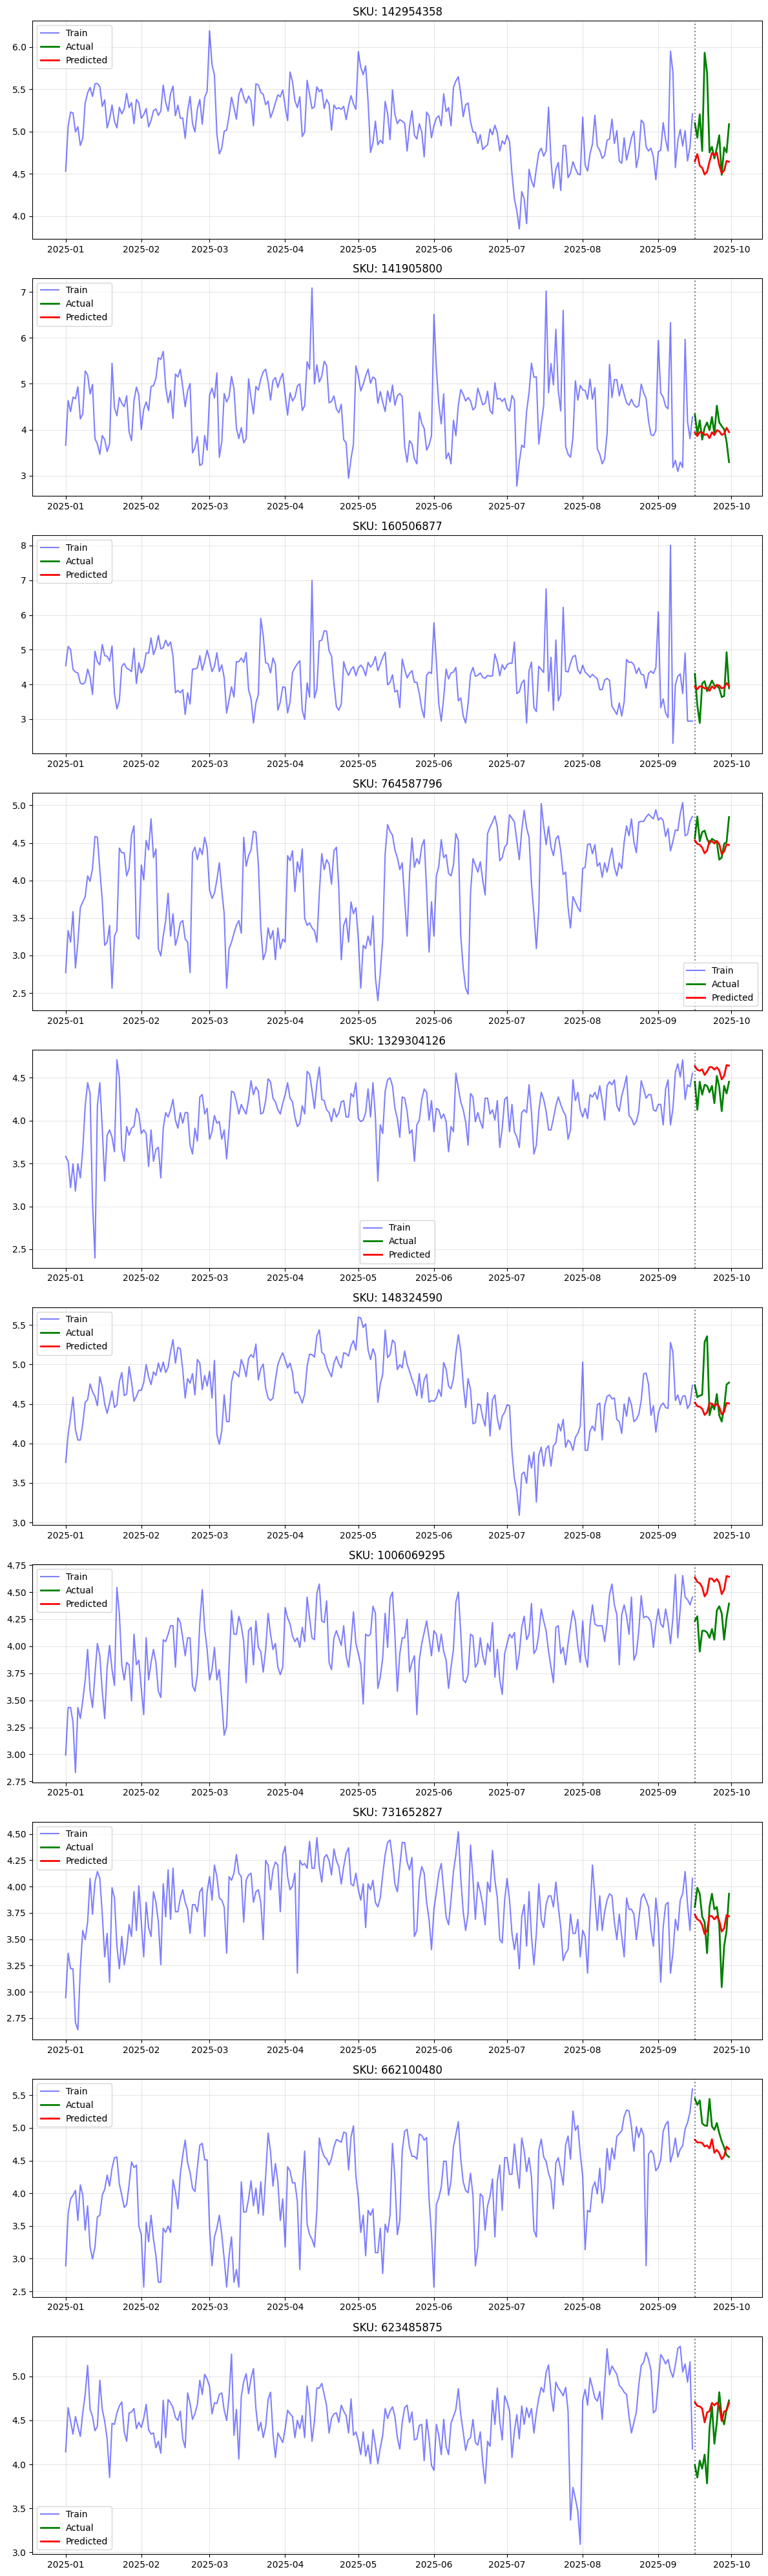

In [41]:
# Добавляем предсказания
test['prediction'] = y_pred

# SKU для просмотра
sku_list = [142954358, 141905800, 160506877, 764587796, 1329304126, 
            148324590, 1006069295, 731652827, 662100480, 623485875]

# Дата обрезки
cut_date = '2025-01-01'

# Графики
fig, axes = plt.subplots(len(sku_list), 1, figsize=(12, 4*len(sku_list)))

for idx, sku in enumerate(sku_list):
    ax = axes[idx]
    
    # Данные SKU
    sku_train = train[train['SKU_id'] == sku].sort_values('date')
    sku_train = sku_train[sku_train['date'] >= cut_date]
    
    sku_test = test[test['SKU_id'] == sku].sort_values('date')
    sku_test = sku_test[sku_test['date'] >= cut_date]
    
    # График
    ax.plot(sku_train['date'], sku_train['real_demand'], 'b-', label='Train', alpha=0.5)
    ax.plot(sku_test['date'], sku_test['real_demand'], 'g-', label='Actual', linewidth=2)
    ax.plot(sku_test['date'], sku_test['prediction'], 'r', label='Predicted', linewidth=2)
    
    ax.axvline(x=test_start_date, color='black', ls=':', alpha=0.5)
    ax.set_title(f'SKU: {sku}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

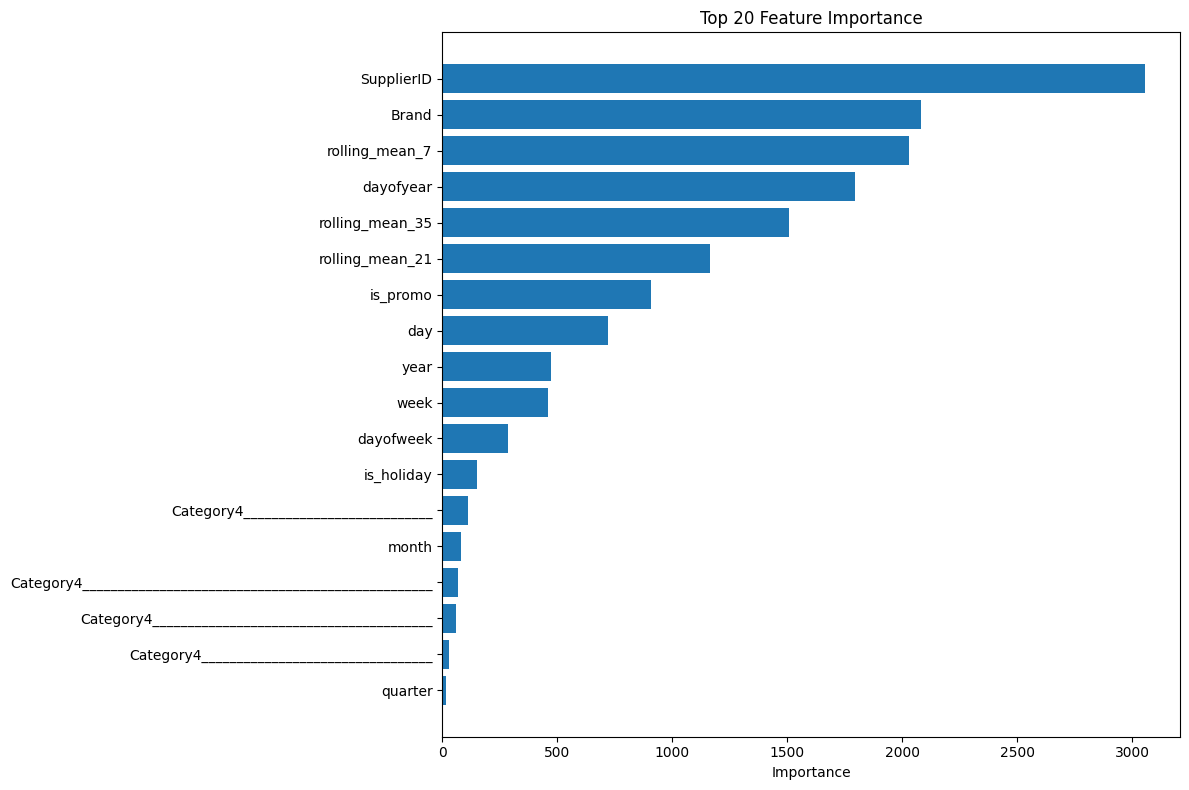

In [43]:
# Важность признаков
feature_names = X_train_transformed.columns.tolist()
importance = model.feature_importances_

# Топ-20
top_n = 20
top_features = pd.DataFrame({
    'feature': feature_names,
    'importance': importance
}).sort_values('importance', ascending=False).head(top_n)

# График
plt.figure(figsize=(12, 8))
plt.barh(range(len(top_features)), top_features['importance'].values)
plt.yticks(range(len(top_features)), top_features['feature'].values)
plt.xlabel('Importance')
plt.title(f'Top {top_n} Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()